# Profiling and Analysis Questions


Clustering
https://web.ist.utl.pt/rmch/dash/guides/Clustering%20in%20Python.html


- what are the top aisle purchase clusters?
- what are the most common timeframe order time clusters (order_dow, order_hour_of_day,days_since_prior_order and weeks_since_prior_order) ?

PCA Resources
- https://www.kaggle.com/code/asindico/customer-segments-with-pca
- https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- https://www.youtube.com/watch?v=8klqIM9UvAc
- https://www.youtube.com/watch?v=FD4DeN81ODY
- https://www.youtube.com/watch?v=HMOI_lkzW08

Clustering resources
- https://github.com/jrkreiger/instacart-analysis/blob/master/instacart-analysis.ipynb
- https://medium.com/towards-data-science/customer-segmentation-using-the-instacart-dataset-17e24be9c0fe


Other resources
- https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-instacart

# NOTAS PROF
- EXPERIMENTAR DBSCAN

Links datasets user and sample
sample: https://drive.google.com/file/d/1yWG47xO_8CLTdYIjo3k3007WxUgFpZjl/view?usp=sharing
total: https://drive.google.com/file/d/1l5lEv0nRKNvBbqmY7hQ23GBc1QnW6moR/view?usp=drive_link
normal zip: https://drive.google.com/file/d/1l5lEv0nRKNvBbqmY7hQ23GBc1QnW6moR/view?usp=drive_link

# File and libraries

In [277]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [278]:
%run "scripts/dslabs_functions.py"

# data functions

In [279]:
%run "scripts/data_functions.py"

data_functions lodaded


# Load

In [280]:
test_data=True
# test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    # Apply the sampling to each group 0.5%
    # sample=0.2

    # data=pd.read_csv(filepath)
    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc_sample.csv')
    # users_df=users_df.sample(frac=sample)



else:
    # Apply the sampling to each group 1%   
    # sample=0.1


    # data=pd.read_csv(filepath)

    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc.csv')
    # users_df=users_df.sample(frac=sample)





users_df = users_df.drop(columns=['reorder_ratio','order_frequency'])

users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41242 entries, 0 to 41241
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  41242 non-null  int64  
 1   total_orders             41242 non-null  int64  
 2   total_products           41242 non-null  int64  
 3   mean_lag_between_orders  41242 non-null  float64
 4   std_lag_between_orders   41242 non-null  float64
 5   mean_reorder_rate        41242 non-null  float64
 6   mean_weekend_order       41242 non-null  float64
 7   mean_order_dow           41242 non-null  float64
 8   mean_order_hour          41242 non-null  float64
 9   median_order_hour        41242 non-null  float64
 10  peak_order_hour          41242 non-null  int64  
 11  order_day_variety        41242 non-null  int64  
 12  unique_products          41242 non-null  int64  
 13  weekend_order_ratio      41242 non-null  float64
 14  order_size_variability

## variable type definition

In [281]:
from pandas import Series, to_numeric, to_datetime


id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']

# data=data.drop(columns=id_cols, axis=1)


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(users_df)
print(variable_types)


{'numeric': ['total_orders', 'total_products', 'mean_lag_between_orders', 'std_lag_between_orders', 'mean_reorder_rate', 'mean_weekend_order', 'mean_order_dow', 'mean_order_hour', 'median_order_hour', 'peak_order_hour', 'order_day_variety', 'unique_products', 'weekend_order_ratio', 'order_size_variability'], 'binary': [], 'date': [], 'symbolic': [], 'id': ['user_id']}


# Cluster Data Prep

## drop nulls

- this will drop all first buying orders from the dataframe

In [282]:
# drop any null values
# data=data.dropna()

users_df=users_df.dropna()

## Drop outliers

In [283]:
numeric_vars = variable_types["numeric"]

summary5: DataFrame = users_df[numeric_vars].describe(include="all")
summary5

,total_orders,total_products,mean_lag_between_orders,std_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,mean_order_hour,median_order_hour,peak_order_hour,order_day_variety,unique_products,weekend_order_ratio,order_size_variability
count,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000
mean,15.593958,2461.780491,15.460017,6.614981,0.432805,0.265485,2.749285,13.546458,13.535789,13.265239,4.698681,15.593958,0.035731,3.967196
std,16.725599,4688.812210,7.188655,3.262821,0.211340,0.215545,1.008183,2.204708,2.833755,3.978134,1.681442,16.725599,0.051923,2.539258
min,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000
25%,5.000000,316.000000,9.557153,4.223882,0.270833,0.098765,2.117647,12.117647,12.000000,10.000000,3.000000,5.000000,0.004171,2.130822
50%,9.000000,965.000000,14.727273,7.042454,0.429691,0.238095,2.755300,13.515970,13.500000,13.000000,5.000000,9.000000,0.015779,3.508089
75%,19.000000,2627.750000,20.644444,9.022754,0.593901,0.388060,3.364696,14.967742,15.000000,16.000000,6.000000,19.000000,0.044025,5.254286
max,99.000000,156235.000000,30.000000,21.213203,0.979310,1.000000,6.000000,22.716667,23.000000,23.000000,7.000000,99.000000,0.333333,33.688547


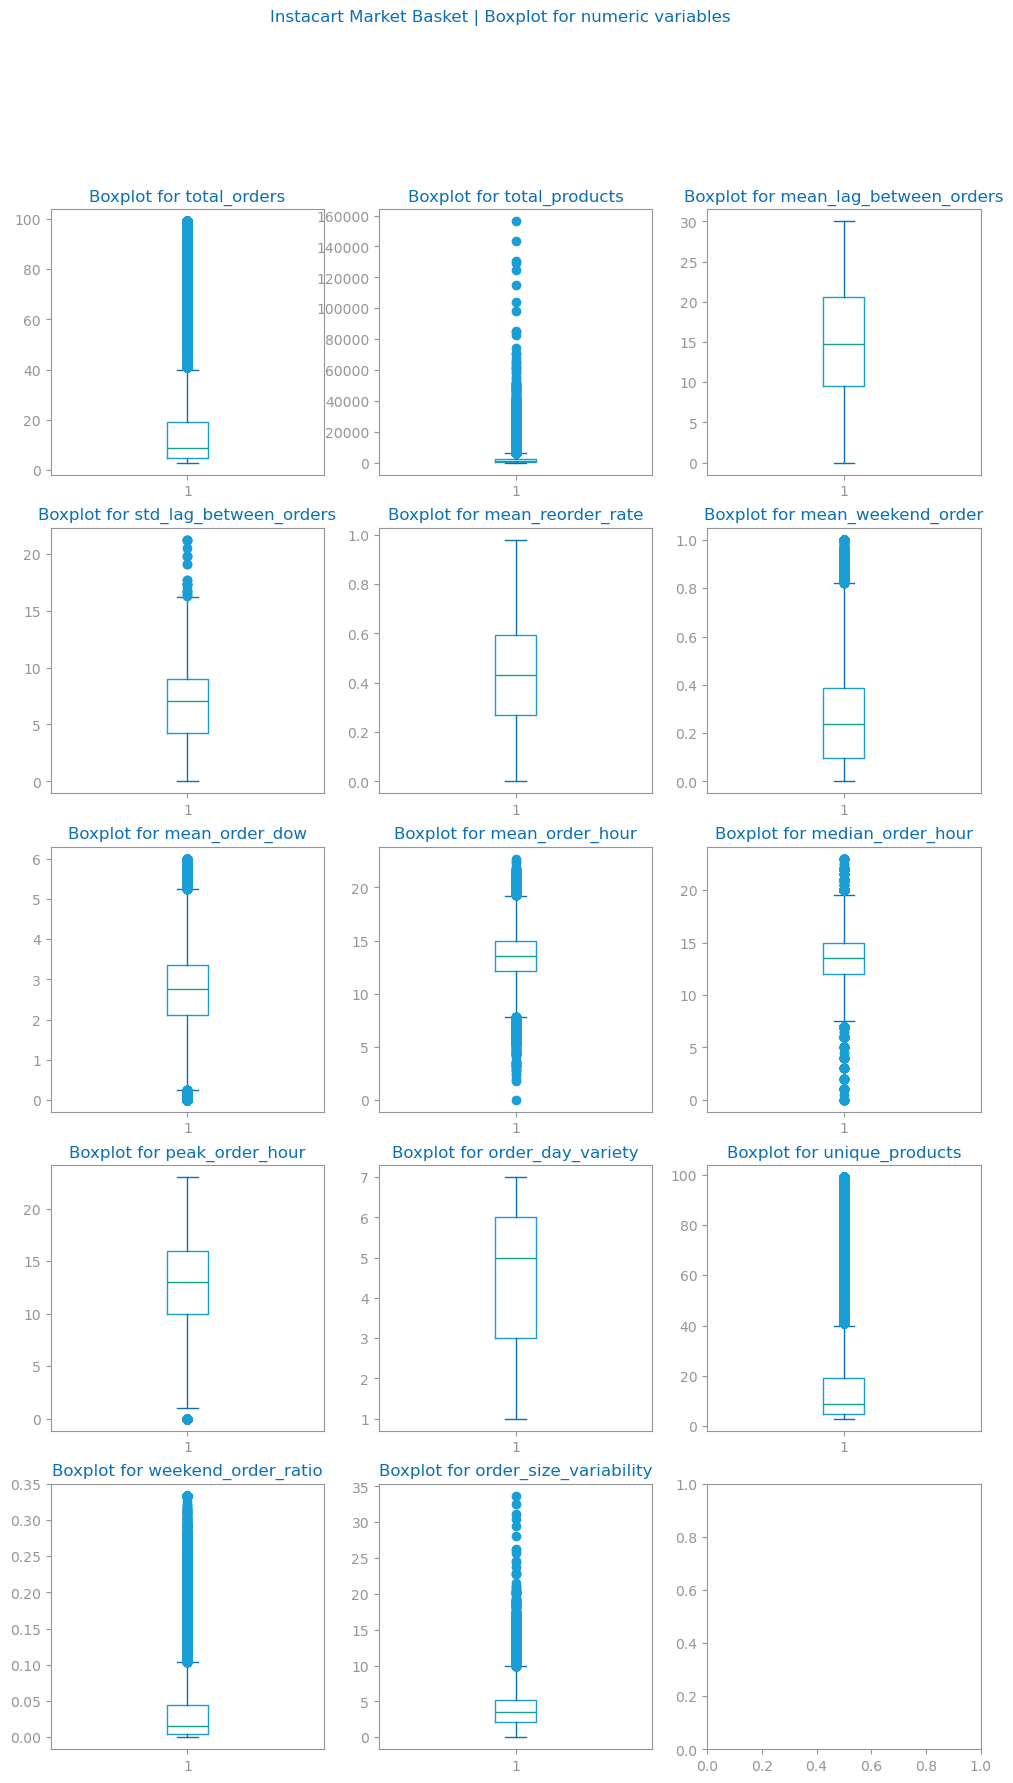

In [284]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(users_df[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [285]:



def truncate_outliers(df, summary, numeric_vars, factor=1):
	for var in numeric_vars:
		if var in summary.columns:
			std = summary[var]['std']
			mean = summary[var]['mean']
			lower_bound = mean - factor * std
			upper_bound = mean + factor * std
			df[var] = np.where(df[var] < lower_bound, lower_bound, df[var])
			df[var] = np.where(df[var] > upper_bound, upper_bound, df[var])
	return df



def drop_numeric_outliers(df, summary, numeric_vars, factor=1):
	for var in numeric_vars:
		if var in summary.columns:
			std = summary[var]['std']
			mean = summary[var]['mean']
			lower_bound = mean - factor * std
			upper_bound = mean + factor * std
			df = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
	return df



users_df = truncate_outliers(users_df, summary5, numeric_vars)


outlier_drop = ['total_orders', 'total_products']
users_df = drop_numeric_outliers(users_df, summary5, outlier_drop)


users_df=users_df[users_df['total_orders']<=15]
users_df=users_df[users_df['total_products']<=1500]
# users_df=users_df[users_df['order_day_variety']<=4]


# users_df = drop_numeric_outliers(users_df, summary5, numeric_vars)

summary5: DataFrame = users_df[numeric_vars].describe(include="all")
summary5

,total_orders,total_products,mean_lag_between_orders,std_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,mean_order_hour,median_order_hour,peak_order_hour,order_day_variety,unique_products,weekend_order_ratio,order_size_variability
count,21882.000000,21882.000000,21882.000000,21882.000000,21882.000000,21882.000000,21882.000000,21882.000000,21882.000000,21882.000000,21882.000000,21882.000000,21882.000000,21882.000000
mean,6.490266,492.361027,17.152353,6.795641,0.346707,0.244622,2.751909,13.594843,13.591469,13.280682,3.958528,6.490266,0.038179,2.947991
std,3.300833,402.241747,5.249852,2.575135,0.133485,0.167429,0.751907,1.638503,2.116387,2.940759,1.074056,3.300833,0.033726,1.494294
min,3.000000,3.000000,8.271362,3.352160,0.221466,0.049941,1.741102,11.341750,10.702034,9.287105,3.017239,3.000000,0.000000,1.427938
25%,4.000000,150.000000,12.646521,3.674235,0.221466,0.049941,2.000000,12.000000,11.000000,10.000000,3.017239,4.000000,0.000000,1.581139
50%,6.000000,384.000000,18.275541,7.229569,0.304348,0.227273,2.760000,13.600000,14.000000,13.000000,4.000000,6.000000,0.030702,2.557461
75%,9.000000,764.000000,22.648672,9.486781,0.437500,0.416667,3.500000,15.268184,16.000000,16.000000,5.000000,9.000000,0.074074,3.837054
max,15.000000,1500.000000,22.648672,9.877803,0.644145,0.481030,3.757469,15.751167,16.369544,17.243373,6.380123,15.000000,0.087654,6.506454


### New Outlier visualization

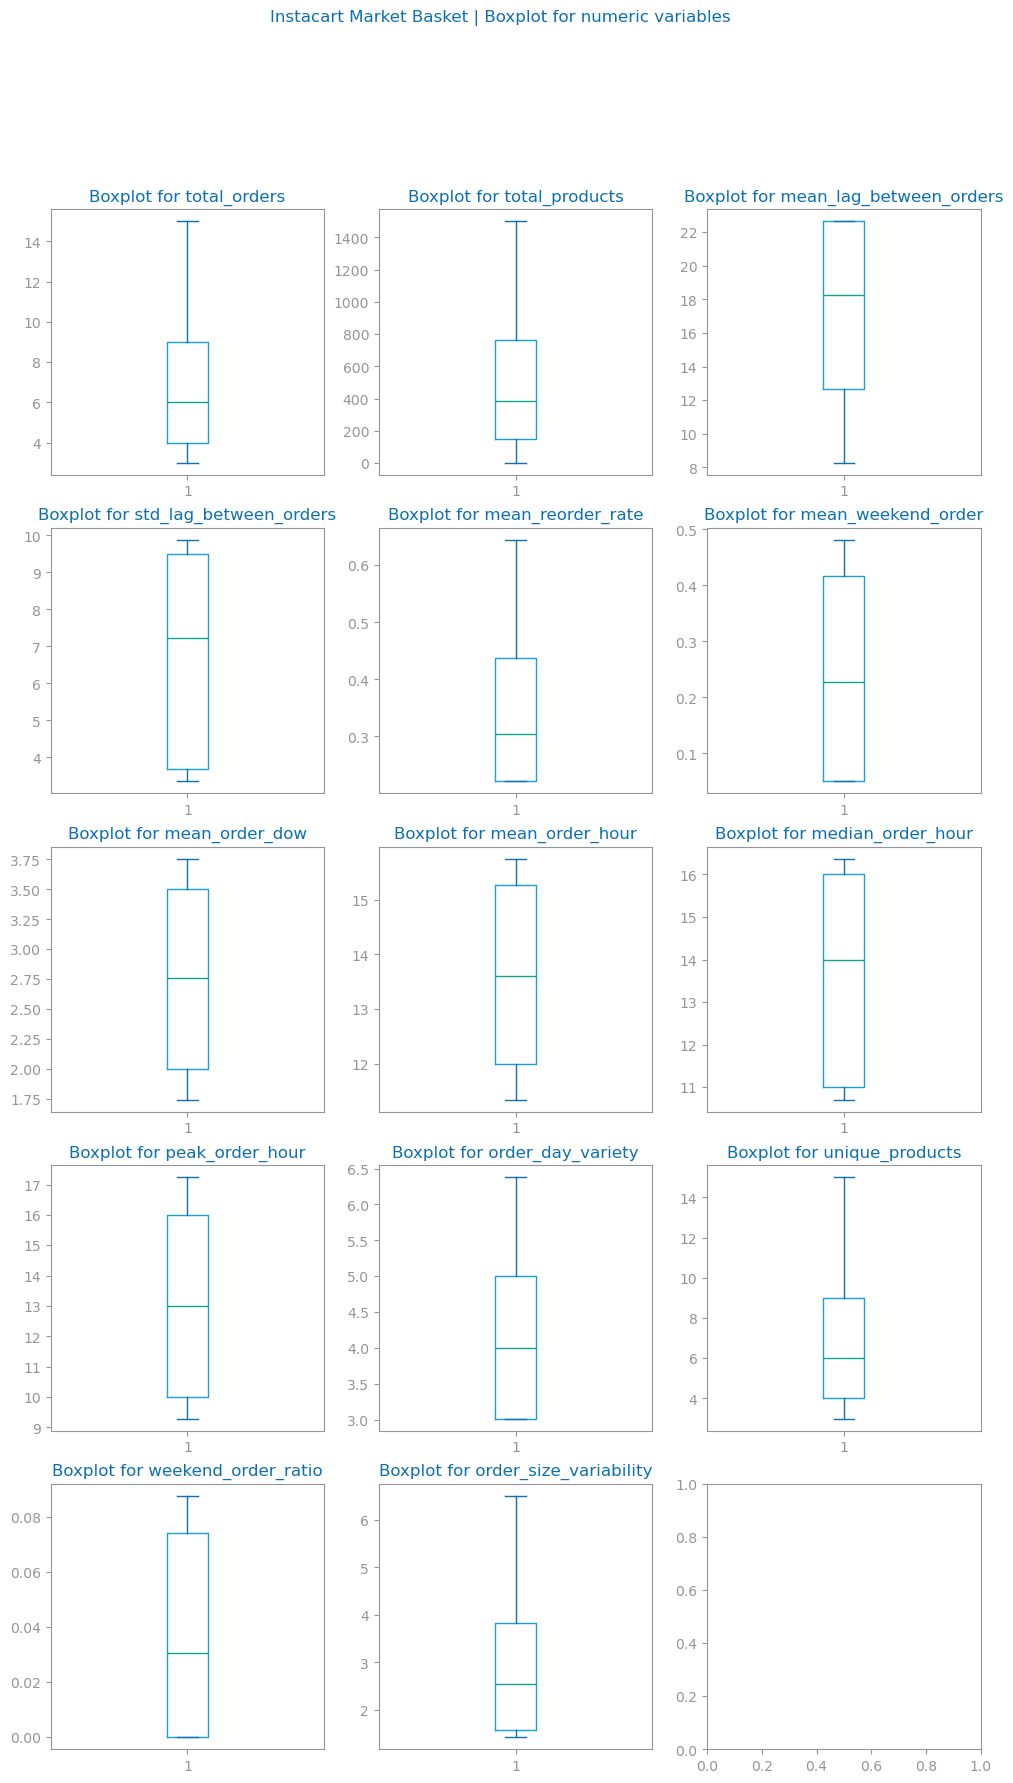

In [286]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(users_df[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

## User Order feature selection and scaling

In [287]:

from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
reorder_numeric_features = users_df[numeric_vars]

# Replace infinite values with NaN
reorder_numeric_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
reorder_numeric_features.dropna(inplace=True)

# Normalize the data
scaler = StandardScaler()
reorder_numeric_features_scaled = scaler.fit_transform(reorder_numeric_features)


# User Order KMEANS clustering

## User Order Elbow Method Studies

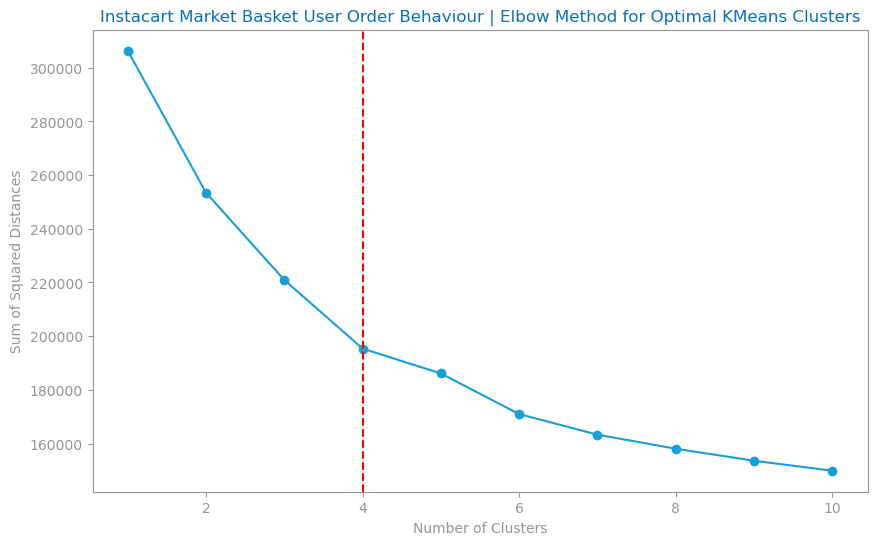

In [288]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define the range of clusters to evaluate
range_n_clusters = list(range(1, 11))

# Initialize an empty list to store the sum of squared distances
ssd = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reorder_numeric_features_scaled)
    ssd.append(kmeans.inertia_)

# Determine the elbow point using KneeLocator
kneedle = KneeLocator(range_n_clusters, ssd, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, marker='o')
plt.title(f'{file_tag} User Order Behaviour | Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, color='r', linestyle='--')

plt.show()

## User Order Sillhouete study for kmeans

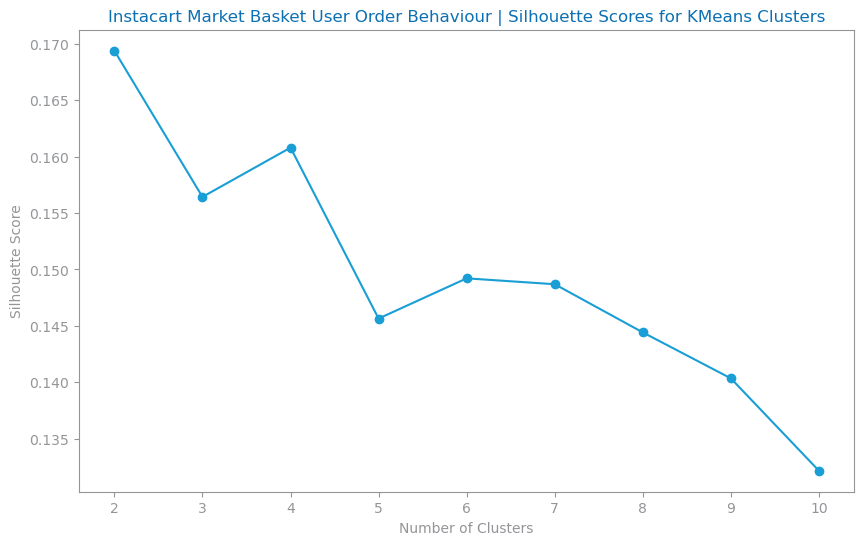

In [289]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 11))

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reorder_numeric_features_scaled)
    silhouette_avg = silhouette_score(reorder_numeric_features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title(f'{file_tag} User Order Behaviour | Silhouette Scores for KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## User Order Kmeans model

In [290]:
# Clustering
reorder_kmeans = KMeans(n_clusters=4, random_state=42)
reorder_y_pred_kmeans = reorder_kmeans.fit_predict(reorder_numeric_features_scaled)

reorder_kmeans.cluster_centers_

array([[-0.56537127, -0.18126321,  0.09268707, -0.20419326, -0.32399712,
         1.09092842,  0.93057721,  0.0335189 ,  0.03150475,  0.01028614,
        -0.47131102, -0.56537127,  1.28368918, -0.0607093 ],
       [-0.4396674 , -0.04528059,  0.10871923, -0.05999776, -0.27324777,
        -0.79968344, -0.72324899,  0.88029375,  0.88534256,  0.82748664,
        -0.36574864, -0.4396674 , -0.65089426,  0.08572957],
       [ 1.39632256,  0.44445624, -0.27108761,  0.43387033,  0.71910003,
         0.12942851,  0.12376762,  0.01887983,  0.01919451,  0.01735245,
         1.24307097,  1.39632256, -0.35665532,  0.0609057 ],
       [-0.38866612, -0.21435803,  0.07483646, -0.15848085, -0.11187861,
        -0.77977488, -0.63991074, -0.92308036, -0.92574011, -0.83972309,
        -0.41258492, -0.38866612, -0.6350494 , -0.07248624]])

# User Order Agglomerative

## User Order Sillouette Study for Agglomerative

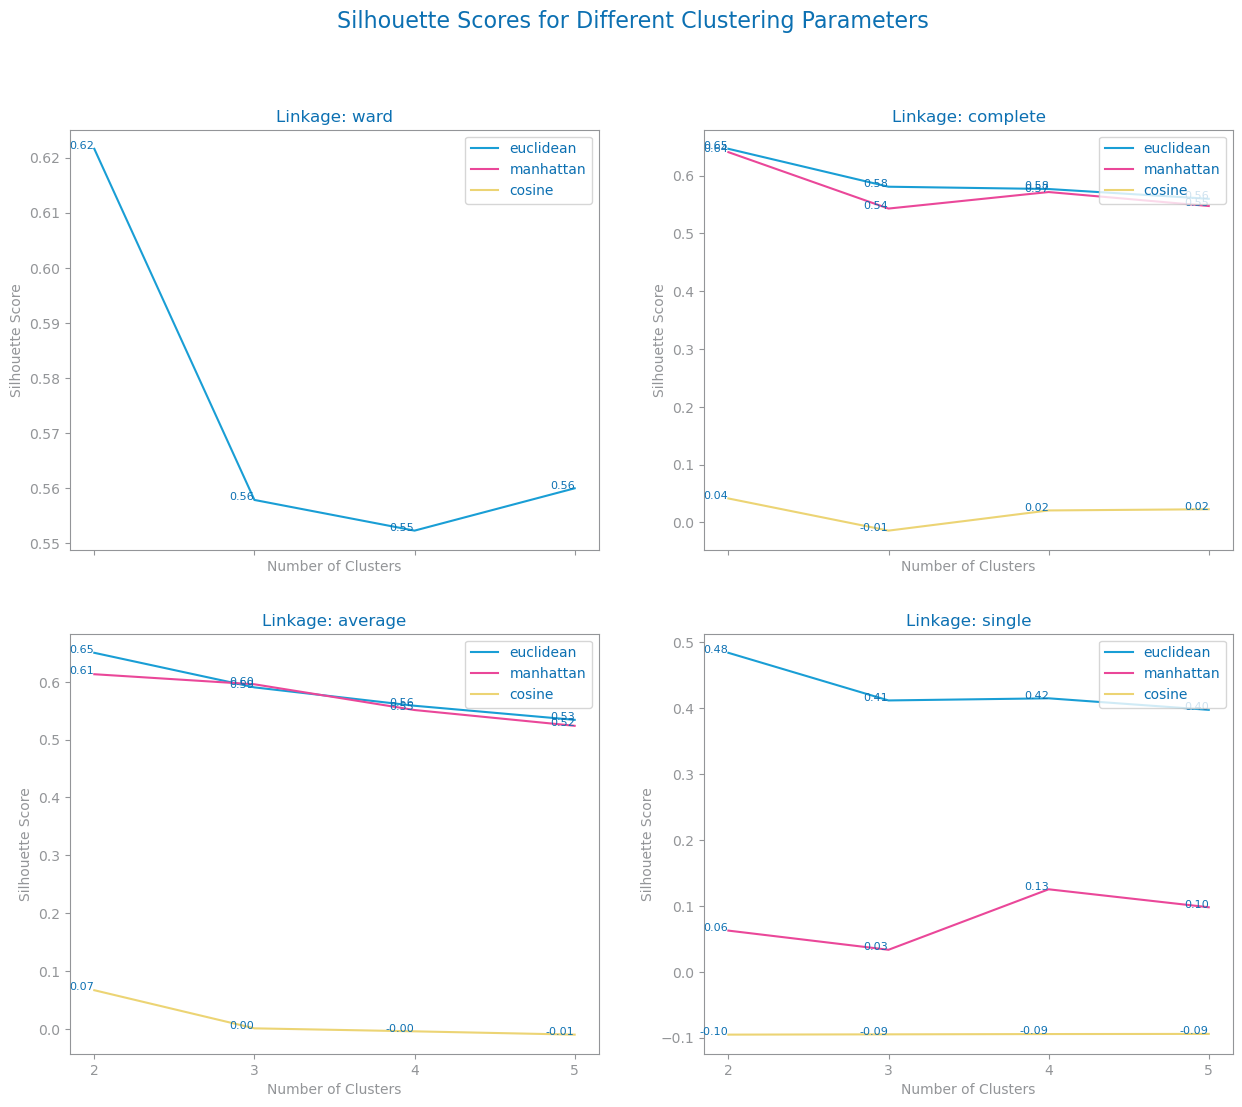

In [291]:
# Create a sample of the reorder_numeric features
reorder_numeric_features_sampled = reorder_numeric_features.sample(frac=0.1, random_state=42)

# Evaluate agglomerative clustering on the sampled data
evaluate_agglomerative_clustering(reorder_numeric_features_sampled, n_clusters_list=[2,3,4,5], scale='no')

## User Order Dendrogram

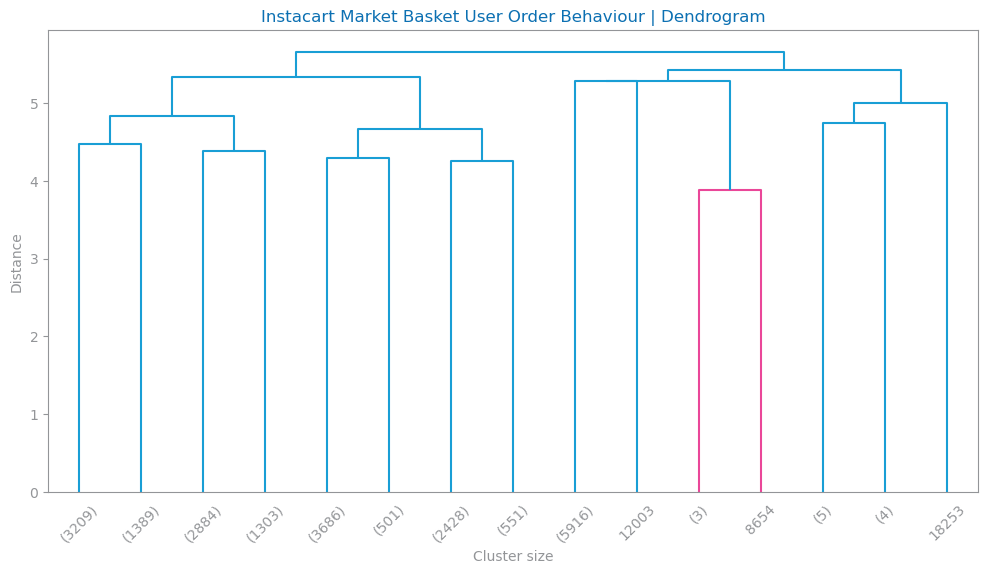

In [292]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(reorder_numeric_features_scaled, method='average', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=3, leaf_rotation=45., leaf_font_size=10., count_sort='descending', distance_sort = 'descending'), 
plt.title(f'{file_tag} User Order Behaviour | Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


## User Order Agglomerative Model

In [293]:
reorder_agglo = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average' )
reorder_y_pred_agglo = reorder_agglo.fit_predict(reorder_numeric_features_scaled)

reorder_y_pred_agglo

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

# User Order DB Scan

## User Order DB Scan Studies

## User Order DB Scan Model Creation

# Final User Order Model Evaluation

In [294]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_kmeans)
silhouette_agglo = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')



Silhouette Score for KMeans: 0.16079461617236518
Silhouette Score for Agglomerative Clustering: 0.09295361116022086


## User Order Cluster Labeling

In [295]:
# Add cluster labels to the dataframe
users_df['kmeans_cluster'] = reorder_y_pred_kmeans
users_df['agglo_cluster'] = reorder_y_pred_agglo

# Display the dataframe with the new cluster labels
users_df.head()

,user_id,total_orders,total_products,mean_lag_between_orders,std_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,mean_order_hour,median_order_hour,peak_order_hour,order_day_variety,unique_products,weekend_order_ratio,order_size_variability,kmeans_cluster,agglo_cluster
0,116121,3.0,14.0,10.600000,4.929503,0.221466,0.166667,1.833333,11.341750,10.702034,10.000000,3.017239,3.0,0.055556,1.427938,3,0
1,96762,7.0,1139.0,17.333333,7.580677,0.328767,0.123288,3.657534,15.410959,13.000000,13.000000,4.000000,7.0,0.017613,6.506454,1,0
2,136823,3.0,377.0,22.086957,6.487141,0.221466,0.303030,3.212121,14.242424,14.000000,16.000000,3.017239,3.0,0.087654,2.278024,0,0
8,81051,10.0,200.0,17.829268,8.114501,0.644145,0.049941,2.190476,13.000000,12.000000,10.000000,4.000000,10.0,0.000000,1.427938,2,1
9,167881,3.0,261.0,22.648672,3.352160,0.221466,0.049941,1.741102,11.341750,10.702034,9.287105,3.017239,3.0,0.014493,3.663192,3,0


### User Order Cluster Counts

In [296]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = users_df.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = users_df.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

KMeans Cluster Counts:
kmeans_cluster
0    6477
1    4870
2    5546
3    4989
dtype: int64

Agglomerative Clustering Counts:
agglo_cluster
0    15951
1     5921
2       10
dtype: int64


In [297]:
# agglo_weird_cluster = users_df[users_df['agglo_cluster']==1]

# agglo_weird_cluster

### User Order cluster boxplots

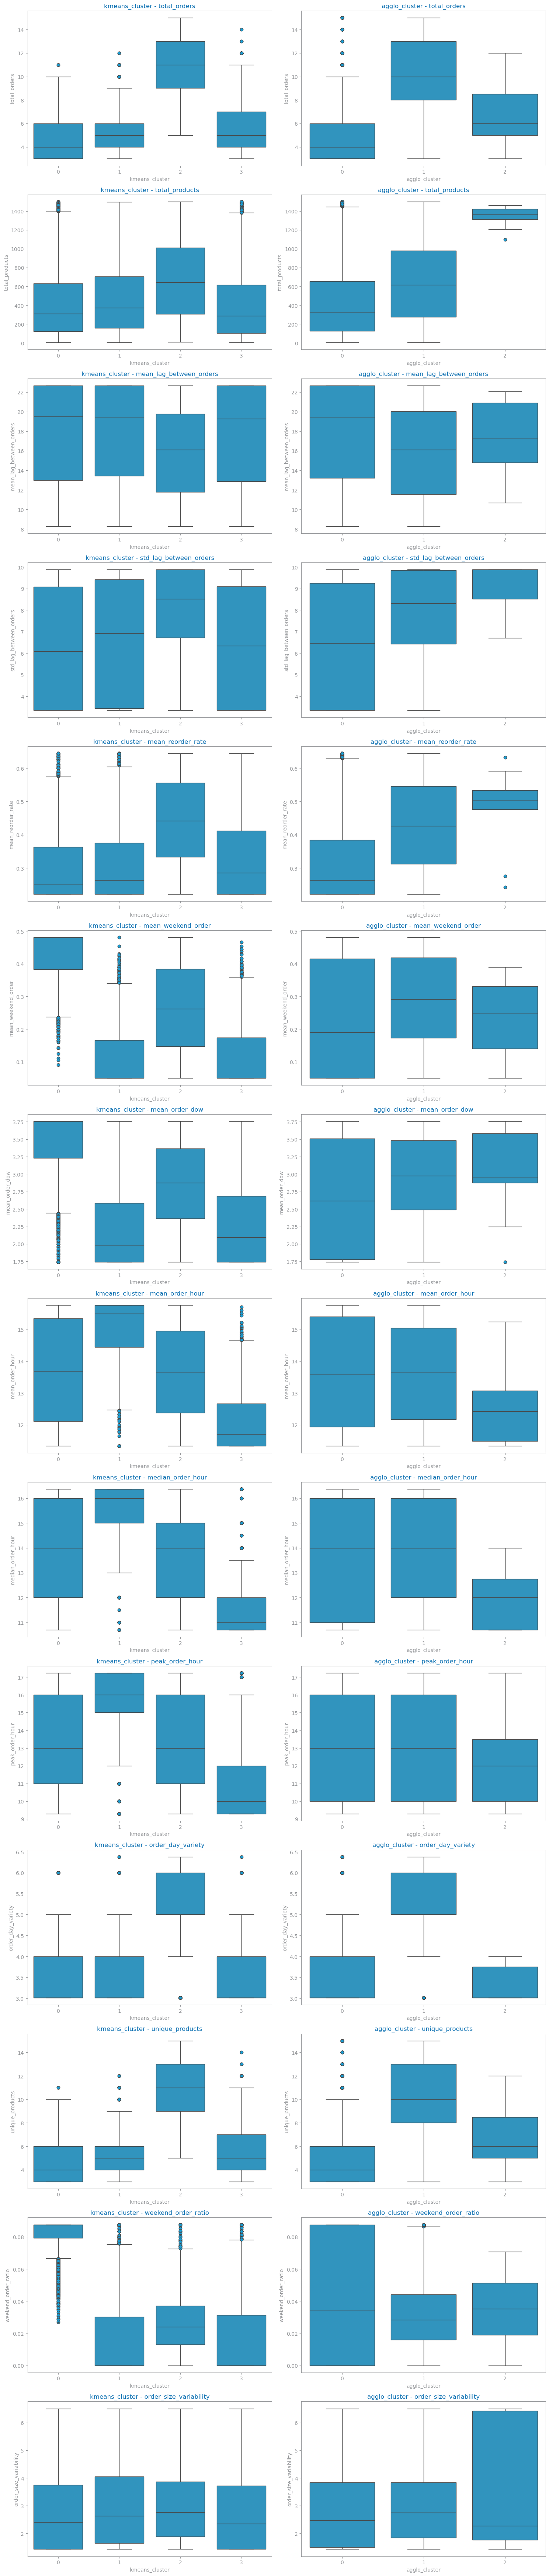

In [298]:

# Example usage
features = numeric_vars


cluster_labels = ['kmeans_cluster', 'agglo_cluster']
plot_cluster_boxplots(users_df, features, cluster_labels)

## User Order PCA visualization

In [299]:
from sklearn.decomposition import PCA

# Visualization
pca_reorder = PCA(n_components=6)
numeric_features_pca = pca_reorder.fit_transform(reorder_numeric_features_scaled)

pca_reorder_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_reorder_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-2.135956,-2.546217,-0.182336,-0.760120,0.991795,-1.189481
1,0.822015,0.683712,-0.297217,2.563348,0.154534,0.189895
2,-2.400156,1.177243,0.425510,-0.053999,-0.749689,0.167072
3,2.069913,-2.017581,-0.592596,-1.815327,-0.295063,0.730104
4,-1.917477,-2.990122,-1.330407,0.745096,-0.137612,0.715878


## User Order pca explained variance ratio

In [300]:
# Fit the PCA model
pca_reorder.fit(reorder_numeric_features_scaled)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance_reorder}')


Explained variance ratio: [0.23719662 0.18746155 0.17788518 0.11506948 0.08060833 0.05685753]


## User Order pca plot

### 2D PCA Plot

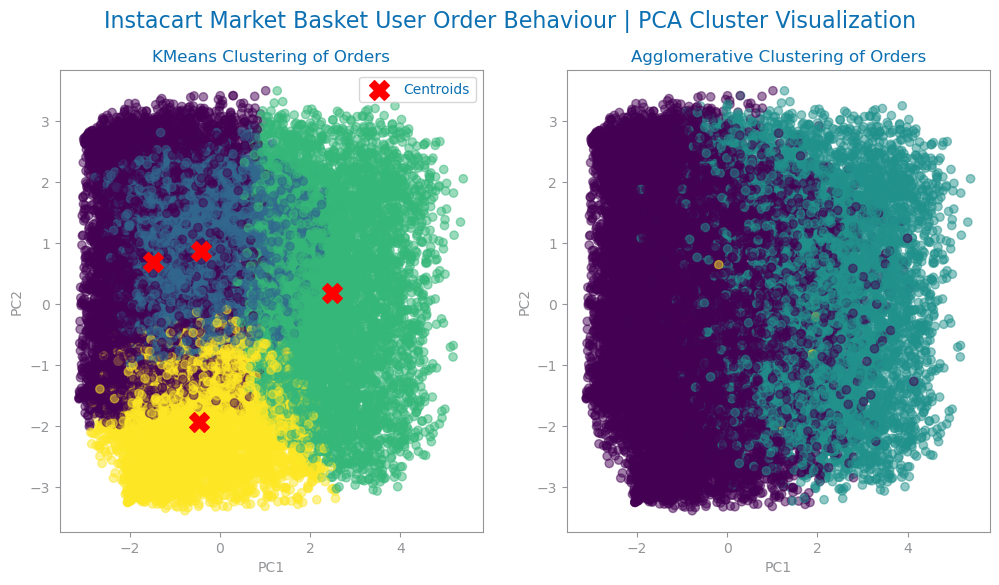

In [301]:
plt.figure(figsize=(12, 6))

# KMeans Clustering
plt.subplot(121)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=reorder_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids = pca_reorder.transform(reorder_kmeans.cluster_centers_)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering of Orders')
plt.legend()

# Agglomerative Clustering
plt.subplot(122)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=reorder_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering of Orders')

plt.suptitle(f"{file_tag} User Order Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

### PCA Plot 3D

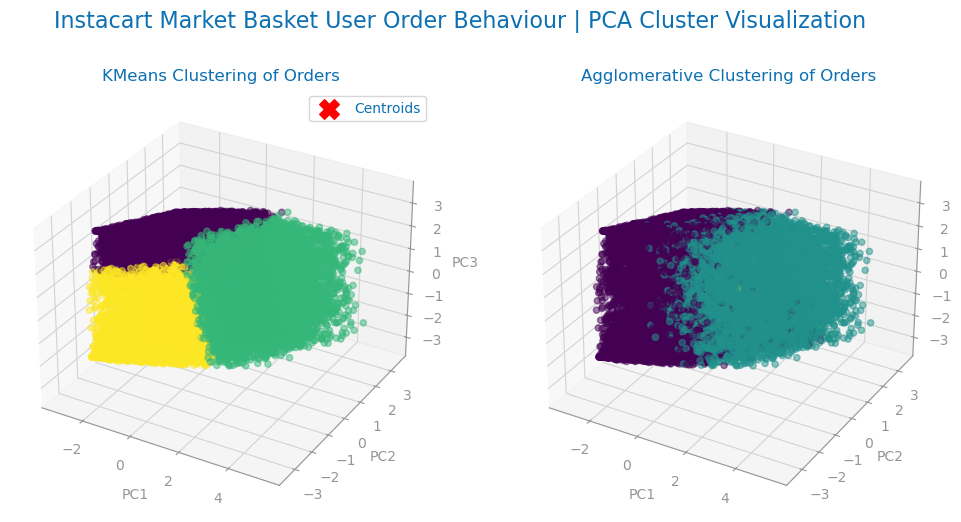

In [302]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# KMeans Clustering
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=reorder_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids_3d = pca_reorder.transform(reorder_kmeans.cluster_centers_)
ax.scatter(kmeans_centroids_3d[:, 0], kmeans_centroids_3d[:, 1], kmeans_centroids_3d[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('KMeans Clustering of Orders')
ax.legend()

# Agglomerative Clustering
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=reorder_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agglomerative Clustering of Orders')

fig.suptitle(f"{file_tag} User Order Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

# outputs
